In [1]:
import os, sys
from collections import Counter
import numpy as np
import numpy.random as rd
import pandas as pd
import scipy as sp
from scipy import stats as st
pd.options.display.max_rows = 999

from sklearn.covariance import GraphicalLasso
from sklearn.preprocessing import StandardScaler
#from sklearn.covariance import GraphLasso

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline

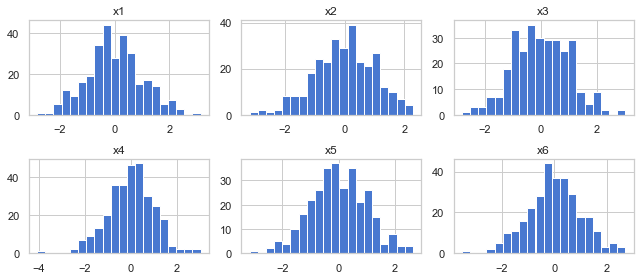

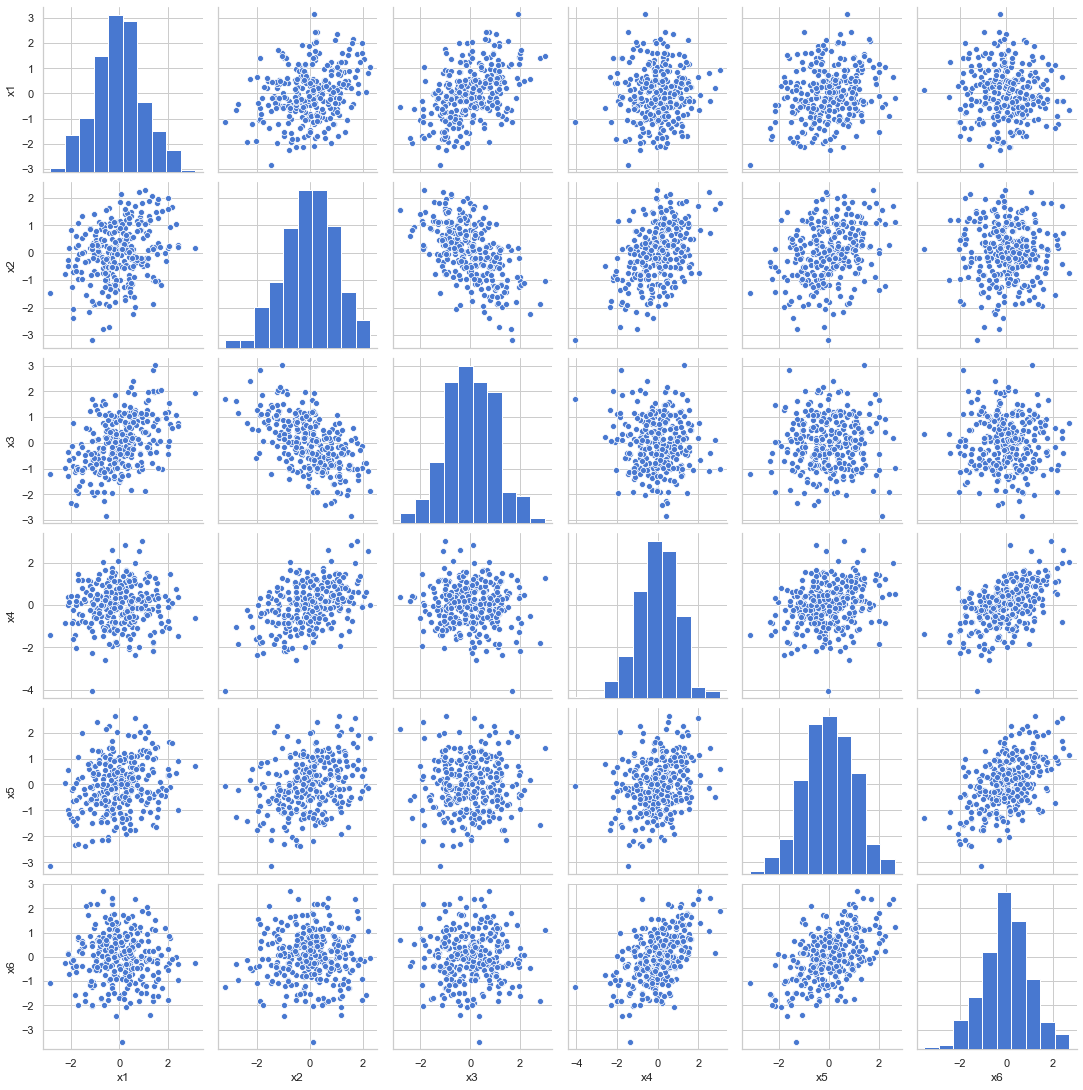

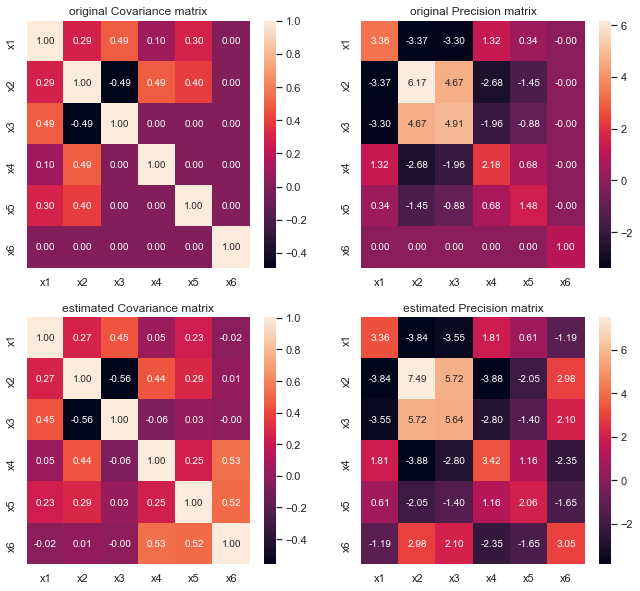

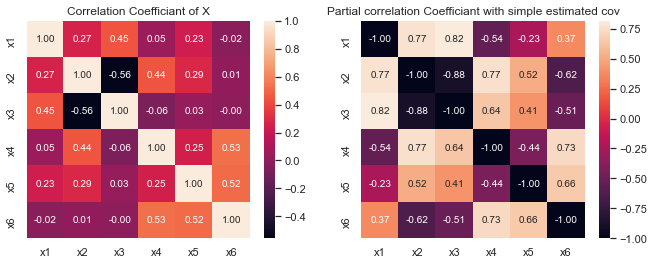

In [2]:
def test_data_gen(disp=False, random_state = 71, size=10000):
    """
    disp: True:グラフを描画, False:描画しない
    random_state: 乱数生成のシード
    size: 生成するデータ数
    """
    
    # 多変量正規分布の乱数生成用の共分散行列
    cov = [[   1, .29, .49, .10, .30,  0],
           [ .29,   1,-.49, .49, .40,  0],
           [ .49,-.49,   1,   0,   0,  0],
           [ .10, .49,   0,   1,   0,  0],
           [ .30, .40,   0,   0,   1,  0],
           [   0,   0,   0,   0,   0,  1]]
    M = len(cov) 
    m = np.zeros(M)
    
    # 6つの変数を作成
    X = st.multivariate_normal.rvs(mean=m, cov=cov, size=size, random_state=random_state)
    
    # x4とx6に相関を持たせる
    X[:,3] += 0.6*X[:,5]
    
    # x5とx6に相関を持たせる
    X[:,4] += 0.6*X[:,5]
    
    M = X.shape[1]
    label = ["x{}".format(i+1) for i in range(M)]

    # 標準化
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    
    # 生成したデータの可視化
    if disp:
        plt.figure(figsize=(3*3, M//3*2))
        for i in range(M):
            plt.subplot(M//3,3,i+1)
            plt.hist(X[:,i],bins=20)
            plt.title(label[i])
        plt.savefig(img_path+"hist.png", dpi=128)
        plt.tight_layout()
        plt.show()
            
        sns.pairplot(pd.DataFrame(X, columns=label))
        plt.savefig(img_path+"X_pair_plot.png", dpi=128)
        plt.show()
        
        plt.figure(figsize=(11,10))
        ax = plt.subplot(2,2,1)
        sns.heatmap(pd.DataFrame(cov), annot=np.asanyarray(cov), fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("original Covariance matrix")
        
        ax = plt.subplot(2,2,2)
        cov_inv = sp.linalg.inv(cov)
        sns.heatmap(pd.DataFrame(cov_inv), annot=np.asanyarray(cov_inv), fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("original Precision matrix")

        ax = plt.subplot(2,2,3)
        X_cov = pd.DataFrame(X).cov()
        sns.heatmap(X_cov, annot=X_cov, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("estimated Covariance matrix")
        
        ax = plt.subplot(2,2,4)
        X_cov_inv = sp.linalg.inv(pd.DataFrame(X).cov())
        sns.heatmap(X_cov_inv, annot=X_cov_inv, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("estimated Precision matrix")
        plt.savefig(img_path+"cov_prec_org_est.png", dpi=128)
        
        rho = np.empty_like(X_cov_inv)
        for i in range(M):
            for j in range(M):
                rho[i, j] = -X_cov_inv[i, j]/np.sqrt(X_cov_inv[i, i]*X_cov_inv[j, j])
        plt.figure(figsize=(11,4))
        
        ax = plt.subplot(121)
        X_cor = pd.DataFrame(X).corr()
        sns.heatmap(pd.DataFrame(X_cor), annot=X_cor, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("Correlation Coefficiant of X")
        
        ax = plt.subplot(122)
        sns.heatmap(pd.DataFrame(rho), annot=rho, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("Partial correlation Coefficiant with simple estimated cov")
        
        
        plt.savefig(img_path+"partial_corr_est.png", dpi=128)
        plt.show()
        
    return X, label

img_path = "img/"
if not os.path.exists(img_path):
    os.mkdir(img_path)

# テストデータ生成
X, label = test_data_gen(disp=True, size=300)
P = X.shape[1]



[graphical_lasso] Iteration   0, cost  2.76e+01, dual gap 5.462e-01
[graphical_lasso] Iteration   1, cost  2.75e+01, dual gap -1.780e-04
[graphical_lasso] Iteration   2, cost  2.75e+01, dual gap -1.566e-06


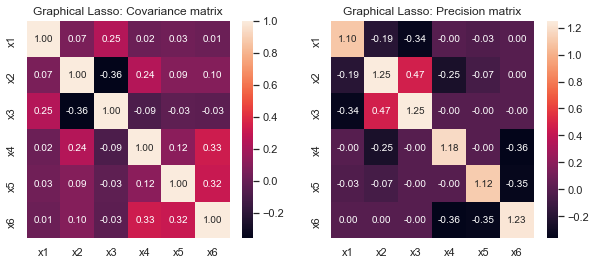

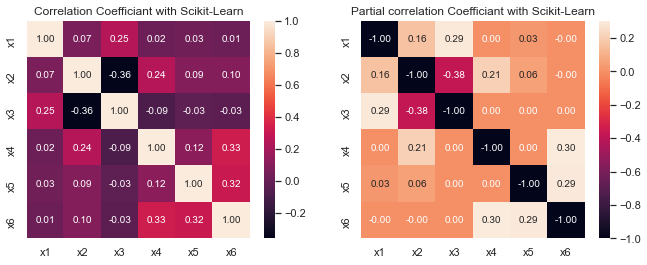

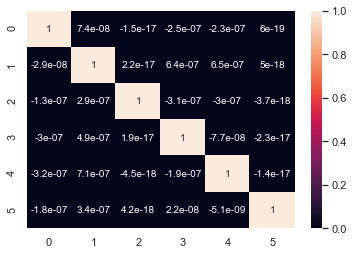

In [3]:


# parametars
alpha = 0.2 # L１正則化パラメーター

# Scikit LearnのGraphical Lassoを使ってブロック降下法で分散共分散行列、精度行列を求める
model = GraphicalLasso(alpha=alpha,
                     max_iter=100,                     
                     verbose=True,
                     assume_centered = True)

model.fit(X)
cov_ = model.covariance_ # 分散共分散行列
prec_ = model.precision_ # 精度行列

# Scikit LearnのGraphical Lassoの結果表示
plt.figure(figsize=(10,4))
ax = plt.subplot(121)
sns.heatmap(cov_, annot=cov_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Covariance matrix")

ax = plt.subplot(122)
sns.heatmap(prec_, annot=prec_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Precision matrix")
plt.savefig(img_path+"glasso_cov_prec.png", dpi=128)
plt.show()

# 相関行列の算出
cor = np.empty_like(cov_)
for i in range(P):
    for j in range(P):
        cor[i, j] = cov_[i, j]/np.sqrt(cov_[i, i]*cov_[j, j])
        
# 偏相関行列の算出
rho = np.empty_like(prec_)
for i in range(P):
    for j in range(P):
        rho[i, j] = -prec_[i, j]/np.sqrt(prec_[i, i]*prec_[j, j])
        
plt.figure(figsize=(11,4))
ax = plt.subplot(122)
sns.heatmap(pd.DataFrame(rho), annot=rho, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Partial correlation Coefficiant with Scikit-Learn")
#plt.savefig(img_path+"partial_corr_sklearn.png", dpi=128)

ax = plt.subplot(121)
sns.heatmap(pd.DataFrame(cor), annot=cor, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Correlation Coefficiant with Scikit-Learn")
plt.savefig(img_path+"corr_pcorr_sklearn.png", dpi=128)
plt.show()

# ちゃんと単位行列になっているか確認してみる。
sns.heatmap(np.dot(cov_, prec_), annot=np.dot(cov_, prec_))
plt.savefig(img_path+"glasso_inv.png", dpi=128)